In [5]:
import numpy as np
import pandas as pd
import torch
import pickle
import matplotlib.pyplot as plt
from lpne.models import DcsfaNmf

MODEL_FILE = "/hpc/home/mk423/Anxiety/FullDataWork/Models/Final_mt_Model_500_epochs.pt"
DATA_PATH = "/work/mk423/Anxiety/"
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"
cus_file = DATA_PATH + "CUS_data.pkl"
proj_file = PROJECT_PATH + "CUS_projection.csv"
mean_file = PROJECT_PATH + "CUS_mean_scores.csv"
model = torch.load(MODEL_FILE,map_location="cpu")
model.device="cpu"


FEATURE_LIST = ['X_power_1_2','X_coh_1_2','X_gc_1_2']
FEATURE_WEIGHT = [10,1,1]

import os, sys
umc_data_tools_path = "/hpc/home/mk423/Anxiety/Universal-Mouse-Code/"
sys.path.append(umc_data_tools_path)
import umc_data_tools as umc_dt

def get_3_net_aucs(s,y,y_group=None):
    
    auc_mean_list = []
    auc_stderr_list =[]
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        mean = np.mean([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"])
        stderr = np.std([auc_dict[key][0] for key in auc_dict.keys() if key != "auc_method"]) / np.sqrt(len(auc_dict.keys()))
        
        auc_mean_list.append(mean)
        auc_stderr_list.append(stderr)
        
    return auc_mean_list, auc_stderr_list

def get_3_net_auc_dict(s,y,y_group=None):
    auc_dict_list = []
    
    if y_group is None:
        y_group = np.ones(s.shape[0])
        
    for i in range(3):
        auc_dict = umc_dt.lpne_auc(y,y,y_group,s[:,i].reshape(-1,1),mannWhitneyU=True)
        auc_dict_list.append(auc_dict)
        
    return auc_dict_list

In [6]:
cus_data_dict = pickle.load(open(cus_file,'rb'))

X = np.hstack([cus_data_dict[feature]*weight for feature,weight in zip(FEATURE_LIST,FEATURE_WEIGHT)])
y = np.array(cus_data_dict['y'])=='S'
y_mouse = cus_data_dict['y_mouse']
y_time = cus_data_dict['y_time']
y_task = cus_data_dict['y_task']
y_Homecage = cus_data_dict['y_Homecage']


In [7]:
for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    print(mouse,np.sum(y_Homecage[mouse_mask==1]))

MouseC5C12 283.0
MouseC5C13 255.0
MouseC5C20 296.0
MouseC5C21 343.0
MouseC5C23 193.0
MouseC5C24 303.0
MouseC5S10 310.0
MouseC5S11 342.0
MouseC5S12 249.0
MouseC5S13 306.0
MouseC5S14 287.0
MouseC5S23 242.0


In [3]:
print(np.unique(y_mouse).shape)

(12,)


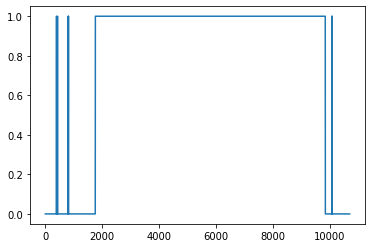

In [4]:
plt.plot(np.isnan(cus_data_dict["y_roi"]))

In [5]:
y_pred_proba = model.predict_proba(X).squeeze()
s = model.project(X)
comp_s = np.sum(s[:,:3] * np.abs(model.classifier[0].weight[0].detach().cpu().numpy()),axis=1)

homecage_stress_vs_control_auc = model.score(X[y_Homecage==1],y[y_Homecage==1].reshape(-1,1))
task_stress_vs_control_auc = model.score(X[y_Homecage==0],y[y_Homecage==0].reshape(-1,1))

hc_vs_task_auc_dict = model.score(X,y_task,y_mouse,return_dict=True)
auc_list = [hc_vs_task_auc_dict[key] for key in list(hc_vs_task_auc_dict.keys())]
mean = np.mean(auc_list)
sterr = np.std(auc_list) / np.sqrt(len(auc_list))

print("Homecage Stress vs Control AUC: {:.3f}".format(homecage_stress_vs_control_auc))
print("In-Task Stress vs Control AUC: {:.3f}".format(task_stress_vs_control_auc))
print("Homecage vs Task AUC: {:.3f} +/- {:.3f} (n={})".format(mean,sterr,len(auc_list)))

Homecage Stress vs Control AUC: 0.655
In-Task Stress vs Control AUC: 0.643
Homecage vs Task AUC: 0.603 +/- 0.022 (n=12)


In [6]:
from scipy.stats import mannwhitneyu as mwu

hc_s = np.logical_and(y,y_Homecage)
hc_c = np.logical_and(y==0,y_Homecage)

U, pval = mwu(np.sum(s[hc_c],axis=1),np.sum(s[hc_s],axis=1))
print(pval)
print(U/(np.sum(hc_s)*np.sum(hc_c)))

task_s = np.logical_and(y,y_Homecage==0)
task_c = np.logical_and(y==0,y_Homecage==0)

U, pval = mwu(np.sum(s[task_c],axis=1),np.sum(s[task_s],axis=1))
print(pval)
print(U/(np.sum(task_c)*np.sum(task_s)))

2.3265960217717483e-79
0.6865777556804878
2.886449070345792e-162
0.6835831226676297


In [7]:
from scipy.stats import mannwhitneyu as mwu

hc_s = np.logical_and(y,y_Homecage)
hc_c = np.logical_and(y==0,y_Homecage)

U, pval = mwu(y_pred_proba[hc_s],y_pred_proba[hc_c])
print(pval)
print(U/(np.sum(hc_s)*np.sum(hc_c)))

task_s = np.logical_and(y,y_Homecage==0)
task_c = np.logical_and(y==0,y_Homecage==0)

U, pval = mwu(y_pred_proba[task_s],y_pred_proba[task_c])
print(pval)
print(U/(np.sum(task_c)*np.sum(task_s)))

2.6463281472247725e-55
0.6549458256780915
7.305605576265049e-99
0.6427266913446491


In [8]:
hc_svc_auc_3_net = get_3_net_auc_dict(s[y_Homecage==1],y[y_Homecage==1])
task_svc_auc_3_net = get_3_net_auc_dict(s[y_Homecage==0],y[y_Homecage==0])
hc_v_task_auc_3_net = get_3_net_auc_dict(s,y_task,y_mouse)

In [9]:
hc_svc_auc_3_net[0][1][0]

0.6837838219374671

In [10]:
y_time_aw_list = []
y_mouse_aw_list = []
y_stressed_aw_list = []
y_velocity_aw_list = []
y_roi_aw_list = []
y_task_aw_list = []
y_homecage_aw_list = []
s_aw_list = []
for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    mask = mouse_mask

    if np.sum(mask) >= 1:

        temp_time = np.array(y_time)[mask==1]
        temp_time_aw = np.arange(np.max(temp_time)+1)

        temp_s = np.zeros((temp_time_aw.shape[0],s.shape[1]))*np.nan
        temp_s[temp_time - 1] = s[mask==1]



        temp_y_mouse = np.array([mouse for _ in temp_time_aw])

        temp_stressed = np.array([mouse[-3]=="S" for mouse in temp_y_mouse])
        temp_task = np.zeros((temp_time_aw.shape[0]))*np.nan
        temp_task[temp_time - 1] = y_task[mask==1]

        temp_homecage = 1 - temp_task

        temp_velocity = np.zeros((temp_time_aw.shape[0]))*np.nan
        temp_velocity[temp_time - 1] = cus_data_dict['labels']['windows']["Average_Velocity_sec"][mask==1]

        temp_roi = np.zeros((temp_time_aw.shape[0]))*np.nan
        temp_roi[temp_time - 1] = cus_data_dict['labels']['windows']["ROI_sec"][mask==1]


        y_time_aw_list.append(temp_time_aw)
        y_mouse_aw_list.append(temp_y_mouse)
        s_aw_list.append(temp_s)
        y_stressed_aw_list.append(temp_stressed)
        y_velocity_aw_list.append(temp_velocity)
        y_roi_aw_list.append(temp_roi)
        y_task_aw_list.append(temp_task)
        y_homecage_aw_list.append(temp_homecage)

y_time_aw = np.hstack(y_time_aw_list)
y_mouse_aw = np.hstack(y_mouse_aw_list)
s_aw = np.vstack(s_aw_list)
y_stressed_aw = np.hstack(y_stressed_aw_list)
y_velocity_aw = np.hstack(y_velocity_aw_list)
y_roi_aw = np.hstack(y_roi_aw_list)
y_task_aw = np.hstack(y_task_aw_list)
y_homecage_aw = np.hstack(y_homecage_aw_list)

coeffs = model.classifier[0].weight[0].detach().cpu().numpy()

In [11]:
results_dict = {
    "composite score":s_aw[:,:3]@coeffs,
    "net 1 scores":s_aw[:,0],
    "net 2 scores":s_aw[:,1],
    "net 3 scores":s_aw[:,2],
    "stressed":y_stressed_aw,
    "mouse":y_mouse_aw,
    "time":y_time_aw,
    "task":y_task_aw,
    "homecage":y_homecage_aw,
    "velocity":y_velocity_aw,
    "roi":y_roi_aw,
    
    "composite Homecage SvC AUC":[homecage_stress_vs_control_auc for i in y_stressed_aw],
    "net 1 Homecage SvC AUC":[hc_svc_auc_3_net[0][1][0] for i in y_stressed_aw],
    "net 2 Homecage SvC AUC":[hc_svc_auc_3_net[1][1][0] for i in y_stressed_aw],
    "net 3 Homecage SvC AUC":[hc_svc_auc_3_net[2][1][0] for i in y_stressed_aw],
    
    "composite Task SvC AUC":[task_stress_vs_control_auc for i in y_stressed_aw],
    "net 1 Task SvC AUC":[task_svc_auc_3_net[0][1][0] for i in y_stressed_aw],
    "net 2 Task SvC AUC":[task_svc_auc_3_net[1][1][0] for i in y_stressed_aw],
    "net 3 Task SvC AUC":[task_svc_auc_3_net[2][1][0] for i in y_stressed_aw],
    
    "composite Homecage vs Task AUC":[hc_vs_task_auc_dict[mouse][0] for mouse in y_mouse_aw],
    "net 1 Homecage vs Task AUC":[hc_v_task_auc_3_net[0][mouse][0] for mouse in y_mouse_aw],
    "net 2 Homecage vs Task AUC":[hc_v_task_auc_3_net[1][mouse][0] for mouse in y_mouse_aw],
    "net 3 Homecage vs Task AUC":[hc_v_task_auc_3_net[2][mouse][0] for mouse in y_mouse_aw],

}

df = pd.DataFrame.from_dict(results_dict)
#df.to_csv(proj_file)
df.head()

,composite score,net 1 scores,net 2 scores,net 3 scores,stressed,mouse,time,task,homecage,velocity,...,net 2 Homecage SvC AUC,net 3 Homecage SvC AUC,composite Task SvC AUC,net 1 Task SvC AUC,net 2 Task SvC AUC,net 3 Task SvC AUC,composite Homecage vs Task AUC,net 1 Homecage vs Task AUC,net 2 Homecage vs Task AUC,net 3 Homecage vs Task AUC
0,1.237014,0.005357,0.066087,0.114225,False,MouseC5C12,0,0.0,1.0,NaN,...,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,0.655446,0.687567,0.637622,0.50719
1,2.013503,0.022029,0.107449,0.008524,False,MouseC5C12,1,0.0,1.0,NaN,...,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,0.655446,0.687567,0.637622,0.50719
2,3.042072,0.050900,0.149458,0.071203,False,MouseC5C12,2,0.0,1.0,NaN,...,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,0.655446,0.687567,0.637622,0.50719
3,2.931853,0.043739,0.147254,0.066603,False,MouseC5C12,3,0.0,1.0,NaN,...,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,0.655446,0.687567,0.637622,0.50719
4,0.763303,0.007801,0.039473,0.039716,False,MouseC5C12,4,0.0,1.0,NaN,...,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,0.655446,0.687567,0.637622,0.50719


In [12]:
#Get per mouse average scores, average scores in HC and average scores in EPM
mouse_list = []
avg_score_list = []
avg_hc_score_list = []
avg_task_score_list = []
stressed_list = []

for mouse in np.unique(y_mouse):
    mouse_mask = y_mouse==mouse
    hc_mouse_mask = np.logical_and(mouse_mask,y_task==0)
    task_mouse_mask = np.logical_and(mouse_mask,y_task==1)
    avg_score = np.mean(s[mouse_mask==1,:3],axis=0)
    avg_score_hc = np.mean(s[hc_mouse_mask==1,:3],axis=0)
    avg_score_task = np.mean(s[task_mouse_mask==1,:3],axis=0)
    
    mouse_list.append(mouse)
    stressed_list.append(mouse[-3]=="S")
    avg_score_list.append(avg_score)
    avg_hc_score_list.append(avg_score_hc)
    avg_task_score_list.append(avg_score_task)
    
avg_score_list = np.array(avg_score_list)
avg_hc_score_list = np.array(avg_hc_score_list)
avg_task_score_list = np.array(avg_task_score_list)

coeffs = np.abs(model.classifier[0].weight[0].detach().cpu().numpy())

mag_score_list = avg_score_list*coeffs
mag_hc_score_list = avg_hc_score_list*coeffs
mag_task_score_list = avg_task_score_list*coeffs

net_impact_scores = mag_score_list / np.sum(mag_score_list,axis=1).reshape(-1,1)
net_hc_scores = mag_hc_score_list / np.sum(mag_hc_score_list,axis=1).reshape(-1,1)
net_task_scores = mag_task_score_list / np.sum(mag_task_score_list,axis=1).reshape(-1,1)

proj_dict = {
    "mouse":mouse_list,
    "stressed":stressed_list,
    
    "composite Homecage SvC AUC":[homecage_stress_vs_control_auc for i in mouse_list],
    "net 1 Homecage SvC AUC":[hc_svc_auc_3_net[0][1][0] for i in mouse_list],
    "net 2 Homecage SvC AUC":[hc_svc_auc_3_net[1][1][0] for i in mouse_list],
    "net 3 Homecage SvC AUC":[hc_svc_auc_3_net[2][1][0] for i in mouse_list],
    
    "composite Task SvC AUC":[task_stress_vs_control_auc for i in mouse_list],
    "net 1 Task SvC AUC":[task_svc_auc_3_net[0][1][0] for i in mouse_list],
    "net 2 Task SvC AUC":[task_svc_auc_3_net[1][1][0] for i in mouse_list],
    "net 3 Task SvC AUC":[task_svc_auc_3_net[2][1][0] for i in mouse_list],
    
    "composite Homecage vs Task AUC":[hc_vs_task_auc_dict[mouse][0] for mouse in mouse_list],
    "net 1 Homecage vs Task AUC":[hc_v_task_auc_3_net[0][mouse][0] for mouse in mouse_list],
    "net 2 Homecage vs Task AUC":[hc_v_task_auc_3_net[1][mouse][0] for mouse in mouse_list],
    "net 3 Homecage vs Task AUC":[hc_v_task_auc_3_net[2][mouse][0] for mouse in mouse_list],
    
    "composite avgScore":np.sum(mag_score_list,axis=1),
    "composite avgHCScore":np.sum(mag_hc_score_list,axis=1),
    "composite avgTaskScore":np.sum(mag_task_score_list,axis=1),
    
    "net 1 avgScore":avg_score_list[:,0],
    "net 1 avgHCScore":avg_hc_score_list[:,0],
    "net 1 avgTaskScore":avg_task_score_list[:,0],
    "net 2 avgScore":avg_score_list[:,1],
    "net 2 avgHCScore":avg_hc_score_list[:,1],
    "net 2 avgTaskScore":avg_task_score_list[:,1],
    "net 3 avgScore":avg_score_list[:,2],
    "net 3 avgHCScore":avg_hc_score_list[:,2],
    "net 3 avgTaskScore":avg_task_score_list[:,2],
    
    "net 1 avgImpact":net_impact_scores[:,0],
    "net 1 avgHCImpact":net_hc_scores[:,0],
    "net 1 avgTaskImpact":net_task_scores[:,0],
    "net 2 avgImpact":net_impact_scores[:,1],
    "net 2 avgHCImpact":net_hc_scores[:,1],
    "net 2 avgTaskImpact":net_task_scores[:,1],
    "net 3 avgImpact":net_impact_scores[:,2],
    "net 3 avgHCImpact":net_hc_scores[:,2],
    "net 3 avgTaskImpact":net_task_scores[:,2],
}
df_mean = pd.DataFrame.from_dict(proj_dict)
#df_mean.to_csv(mean_file)
df_mean.head()

,mouse,stressed,composite Homecage SvC AUC,net 1 Homecage SvC AUC,net 2 Homecage SvC AUC,net 3 Homecage SvC AUC,composite Task SvC AUC,net 1 Task SvC AUC,net 2 Task SvC AUC,net 3 Task SvC AUC,...,net 3 avgTaskScore,net 1 avgImpact,net 1 avgHCImpact,net 1 avgTaskImpact,net 2 avgImpact,net 2 avgHCImpact,net 2 avgTaskImpact,net 3 avgImpact,net 3 avgHCImpact,net 3 avgTaskImpact
0,MouseC5C12,False,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.049151,0.187422,0.175768,0.191747,0.803796,0.814320,0.799890,0.008782,0.009912,0.008363
1,MouseC5C13,False,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.032298,0.323936,0.331796,0.321190,0.669025,0.660813,0.671895,0.007039,0.007391,0.006915
2,MouseC5C20,False,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.039095,0.298477,0.289750,0.301890,0.681994,0.688700,0.679372,0.019529,0.021550,0.018738
3,MouseC5C21,False,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.042562,0.269881,0.256204,0.278279,0.717545,0.730031,0.709879,0.012574,0.013765,0.011843
4,MouseC5C23,False,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.037344,0.331142,0.365631,0.313480,0.652078,0.616568,0.670263,0.016780,0.017801,0.016257


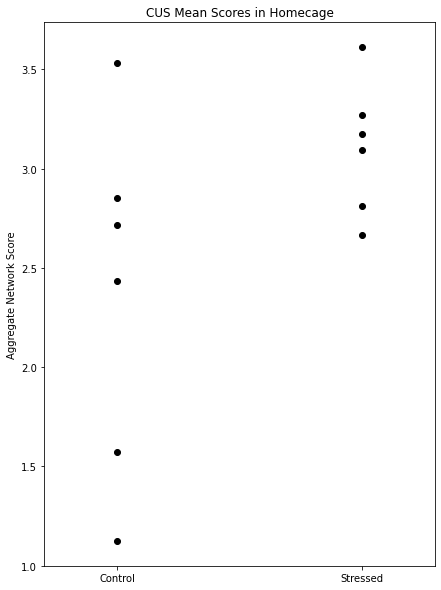

In [15]:
plt.figure(figsize=(7,10))
xa = np.zeros(df_mean[df_mean["stressed"]==False]["composite avgHCScore"].shape)
ya = df_mean[df_mean["stressed"]==False]["composite avgHCScore"]

xb = np.ones(df_mean[df_mean["stressed"]==True]["composite avgHCScore"].shape)
yb = df_mean[df_mean["stressed"]==True]["composite avgHCScore"]

plt.scatter(xa,ya,color="black")
plt.scatter(xb,yb,color="black")
plt.xlim([-.3,1.3])
plt.xticks([0,1],["Control","Stressed"])
plt.ylabel("Aggregate Network Score")
plt.title("CUS Mean Scores in Homecage")
plt.savefig(FIGURE_PATH + "CUS Mean Scores in Homecage.svg")
plt.show()

In [16]:
from scipy.stats import ranksums

stat, pval = ranksums(yb,ya)
print(pval)

0.10931457620866636


In [13]:
df_mean["OpenArmPerc"] = [7.92561,
8.46916,
24.74087,
16.73718, #May be mislabeled
15.71615,
20.4452,
7.95148,
7.86974,
5.31543,
1.369729,
3.039897,
2.166308]

df_mean["OpenArmFreq"] = [16,
26,
96,
116, #May be mislabeled
70,
59,
37,
37,
6,
26,
14,
40,
                         ]

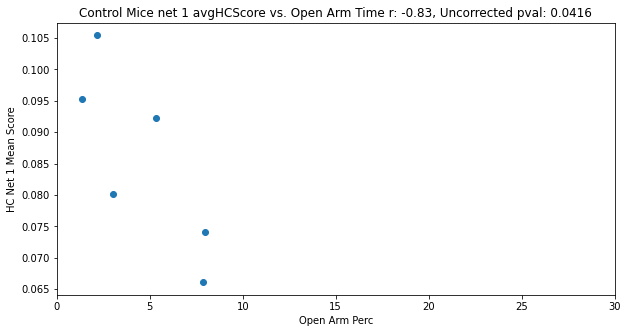

In [42]:
from scipy.stats import spearmanr
score_key = "net 1 avgHCScore"
stat, pval = spearmanr(df_mean[score_key][df_mean["stressed"]==1],df_mean["OpenArmPerc"][df_mean["stressed"]==1])

plt.figure(figsize=(10,5))
plt.scatter(df_mean["OpenArmPerc"][df_mean["stressed"]==1],df_mean[score_key][df_mean["stressed"]==1])
plt.xlabel("Open Arm Perc")
plt.ylabel("HC Net 1 Mean Score")
plt.title("Control Mice {} vs. Open Arm Time r: {:.2f}, Uncorrected pval: {:.4f}".format(score_key,stat,pval))
#plt.savefig(FIGURE_PATH + "CUS-EPM Avg Score vs OA Time-Perc Spearman.svg")
plt.xlim([0,30])
plt.show()

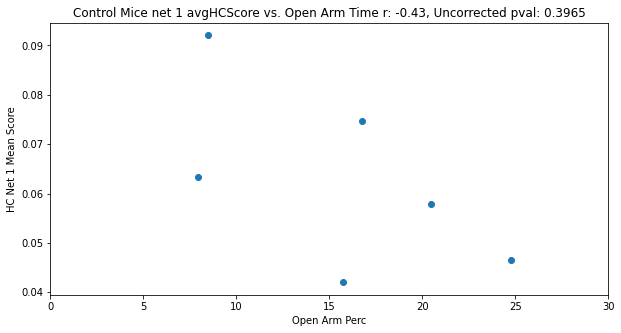

In [43]:
from scipy.stats import spearmanr
score_key = "net 1 avgHCScore"
stat, pval = spearmanr(df_mean[score_key][df_mean["stressed"]==0],df_mean["OpenArmPerc"][df_mean["stressed"]==0])

plt.figure(figsize=(10,5))
plt.scatter(df_mean["OpenArmPerc"][df_mean["stressed"]==0],df_mean[score_key][df_mean["stressed"]==0])
plt.xlabel("Open Arm Perc")
plt.ylabel("HC Net 1 Mean Score")
plt.title("Control Mice {} vs. Open Arm Time r: {:.2f}, Uncorrected pval: {:.4f}".format(score_key,stat,pval))
#plt.savefig(FIGURE_PATH + "CUS-EPM Avg Score vs OA Time-Perc Spearman.svg")
plt.xlim([0,30])
plt.show()

In [ ]:
df_trim

,mouse,stressed,composite Homecage SvC AUC,net 1 Homecage SvC AUC,net 2 Homecage SvC AUC,net 3 Homecage SvC AUC,composite Task SvC AUC,net 1 Task SvC AUC,net 2 Task SvC AUC,net 3 Task SvC AUC,...,net 2 avgImpact,net 2 avgHCImpact,net 2 avgTaskImpact,net 3 avgImpact,net 3 avgHCImpact,net 3 avgTaskImpact,OpenArmPerc,OpenArmFreq,const,net1AvgHCScore
0,MouseC5C12,0,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.803796,0.814320,0.799890,0.008782,0.009912,0.008363,7.925610,16,1,0.063344
1,MouseC5C13,0,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.669025,0.660813,0.671895,0.007039,0.007391,0.006915,8.469160,26,1,0.092053
2,MouseC5C20,0,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.681994,0.688700,0.679372,0.019529,0.021550,0.018738,24.740870,96,1,0.046602
3,MouseC5C21,0,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.717545,0.730031,0.709879,0.012574,0.013765,0.011843,16.737180,116,1,0.074628
4,MouseC5C23,0,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.652078,0.616568,0.670263,0.016780,0.017801,0.016257,15.716150,70,1,0.041974
5,MouseC5C24,0,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.748154,0.749324,0.747754,0.013254,0.017484,0.011804,20.445200,59,1,0.057893
6,MouseC5S10,1,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.794944,0.791607,0.796540,0.007437,0.007550,0.007383,7.951480,37,1,0.074077
7,MouseC5S11,1,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.759065,0.754593,0.761589,0.016518,0.015208,0.017258,7.869740,37,1,0.066072
8,MouseC5S12,1,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.676908,0.651008,0.685372,0.009607,0.009943,0.009497,5.315430,6,1,0.092334
9,MouseC5S13,1,0.654946,0.683784,0.636079,0.528301,0.642727,0.651771,0.632575,0.599365,...,0.707839,0.693667,0.713208,0.011292,0.012594,0.010799,1.369729,26,1,0.095251


In [31]:
np.unique(df_trim.mouse).shape

(12,)

In [32]:
import statsmodels.api as sm
import statsmodels.genmod.families.links as links

#Add a constant
df_mean['const'] = 1

df_trim = df_mean.copy()
df_trim["net1AvgTaskScore"] = df_trim["net 1 avgTaskScore"]
df_trim["stressed"] = df_trim["stressed"].astype(int)

#Define GLMs
outcome_model = sm.OLS.from_formula("OpenArmPerc ~ net1AvgTaskScore + stressed + const",df_trim)
mediator_model = sm.OLS.from_formula("net1AvgTaskScore ~ stressed",df_trim)

causal_model= sm.stats.Mediation(outcome_model, mediator_model, exposure="stressed",mediator="net1AvgTaskScore").fit()

acme = np.mean(causal_model.ACME_avg)
ade = np.mean(causal_model.ADE_avg)

In [33]:
causal_model.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-3.460423,-9.876369,2.056450,0.234
ACME (treated),-3.460423,-9.876369,2.056450,0.234
ADE (control),-7.526545,-11.733378,-3.360815,0.000
ADE (treated),-7.526545,-11.733378,-3.360815,0.000
Total effect,-10.986968,-17.478494,-3.997090,0.002
Prop. mediated (control),0.302683,-0.428216,0.662398,0.232
Prop. mediated (treated),0.302683,-0.428216,0.662398,0.232
ACME (average),-3.460423,-9.876369,2.056450,0.234
ADE (average),-7.526545,-11.733378,-3.360815,0.000
Prop. mediated (average),0.302683,-0.428216,0.662398,0.232


In [30]:
import statsmodels.api as sm
import statsmodels.genmod.families.links as links

#Add a constant
df_mean['const'] = 1

df_trim = df_mean.copy()
df_trim["net1AvgHCScore"] = df_trim["net 1 avgHCScore"]
df_trim["stressed"] = df_trim["stressed"].astype(int)

#Define GLMs
outcome_model = sm.OLS.from_formula("OpenArmPerc ~ net1AvgHCScore + stressed + const",df_trim)
mediator_model = sm.OLS.from_formula("net1AvgHCScore ~ stressed",df_trim)

causal_model= sm.stats.Mediation(outcome_model, mediator_model, exposure="stressed",mediator="net1AvgHCScore").fit()

acme = np.mean(causal_model.ACME_avg)
ade = np.mean(causal_model.ADE_avg)

In [31]:
causal_model.summary()

,Estimate,Lower CI bound,Upper CI bound,P-value
ACME (control),-4.478153,-11.682171,0.185018,0.064
ACME (treated),-4.478153,-11.682171,0.185018,0.064
ADE (control),-6.658328,-12.691389,-0.729306,0.028
ADE (treated),-6.658328,-12.691389,-0.729306,0.028
Total effect,-11.136482,-17.686015,-4.940971,0.000
Prop. mediated (control),0.377277,-0.023971,0.888816,0.064
Prop. mediated (treated),0.377277,-0.023971,0.888816,0.064
ACME (average),-4.478153,-11.682171,0.185018,0.064
ADE (average),-6.658328,-12.691389,-0.729306,0.028
Prop. mediated (average),0.377277,-0.023971,0.888816,0.064


In [34]:
mediator_model = mediator_model.fit()

In [35]:
mediator_model.summary()

/opt/conda/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         net1AvgHCScore   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     5.588
Date:                Thu, 09 Nov 2023   Prob (F-statistic):             0.0397
Time:                        11:26:45   Log-Likelihood:                 33.168
No. Observations:                  12   AIC:                            -62.34
Df Residuals:                      10   BIC:                            -61.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0627      0.007      9.199      0.000       0.048       0.078
stressed       0.0228      0.010      2.364      0.040       0.001       0.044
==============================================================================
Omnibus:                        0.660   Durbin-Watson:                   2.389
Prob(Omnibus):                  0.719   Jarque-Bera (JB):                0.640
Skew:                           0.319   Prob(JB):                        0.726
Kurtosis:                       2.065   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

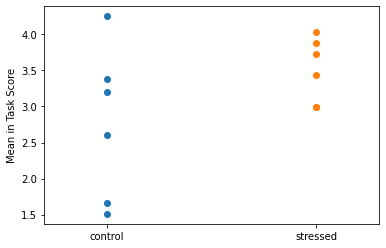

In [69]:
plt.scatter(np.zeros(6),df_trim[df_trim.stressed==0]["compAvgTaskScore"])
plt.scatter(np.ones(6),df_trim[df_trim.stressed==1]["compAvgTaskScore"])
plt.xticks([0,1],["control","stressed"])
plt.ylabel("Mean in Task Score")
plt.xlim([-.3,1.3])
plt.show()

### Causal Mediation Analysis for N-Second Windows

In [35]:
n_windows = 5

sliced_data_dict = {}
sliced_data_dict["scores"] = []
sliced_data_dict["mouse"] = []
sliced_data_dict["task"] = []
sliced_data_dict["stress"] = []
sliced_data_dict["roi"] = []

for mouse in np.unique(df["mouse"]):
    
    temp_scores = df[np.logical_and(df["mouse"]==mouse,~np.isnan(df["roi"]))]["composite score"].values
    temp_mouse = df[np.logical_and(df["mouse"]==mouse,~np.isnan(df["roi"]))]["mouse"].values
    temp_task = df[np.logical_and(df["mouse"]==mouse,~np.isnan(df["roi"]))]["task"].values
    temp_stress = df[np.logical_and(df["mouse"]==mouse,~np.isnan(df["roi"]))]["stressed"].values
    temp_roi = df[np.logical_and(df["mouse"]==mouse,~np.isnan(df["roi"]))]["roi"].values
    
    overflow = temp_scores.shape[0] % n_windows
    n_included = temp_scores[:-overflow].reshape(-1,n_windows).shape[0]
    
    sliced_data_dict["scores"].append(np.mean(temp_scores[:-overflow].reshape(-1,n_windows),axis=1))
    sliced_data_dict["mouse"].append([mouse for _ in range(n_included)])
    sliced_data_dict["task"].append(np.mean(temp_task[:-overflow].reshape(-1,n_windows),axis=1))
    sliced_data_dict["stress"].append([temp_stress[0] for _ in range(n_included)])
    sliced_data_dict["roi"].append(np.mean(temp_roi[:-overflow].reshape(-1,n_windows),axis=1))
    
    
sliced_data_dict["scores"] = np.array(sliced_data_dict["scores"]).squeeze()
sliced_data_dict["mouse"] = np.array(sliced_data_dict["mouse"]).squeeze()
sliced_data_dict["task"] = np.array(sliced_data_dict["task"]).squeeze()
sliced_data_dict["stress"] = np.array(sliced_data_dict["stress"]).squeeze()
sliced_data_dict["roi"] = np.array(sliced_data_dict["roi"]).squeeze()

df_temp = pd.DataFrame.from_dict(sliced_data_dict)
df_temp.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/co

,scores,mouse,task,stress,roi
0,"[1.997549135141116, 3.023564880478781, 3.91166...","[MouseC5C12, MouseC5C12, MouseC5C12, MouseC5C1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,"[2.4661940857703293, 3.0436217686608082, 2.767...","[MouseC5C13, MouseC5C13, MouseC5C13, MouseC5C1...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[False, False, False, False, False, False, Fal...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,[],[],[],[],[]
3,[],[],[],[],[]
4,[],[],[],[],[]


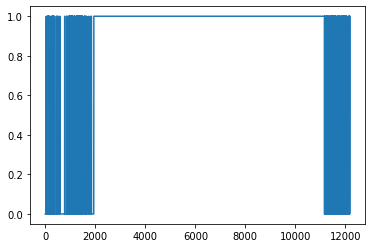

In [37]:
plt.plot(np.isnan(df["roi"]))

In [25]:
df["composite score"].values

array([1.23701438, 2.0135026 , 3.04207212, ..., 2.95584943, 3.59463264,
              nan])

### Entry Event Plots

In [70]:
rois = df["roi"].to_numpy()
scores = df["agg score"].to_numpy()
mouse = df["mouse"].to_numpy()
intask = df["task"].to_numpy()
time = df["time"].to_numpy()
roi_mask = 1 - np.isnan(rois)
mask = np.logical_and(roi_mask,intask)

filt_rois = rois[mask==1]%2
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

In [71]:
mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []
for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==1 and temp_rois[idx-1]==0:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])

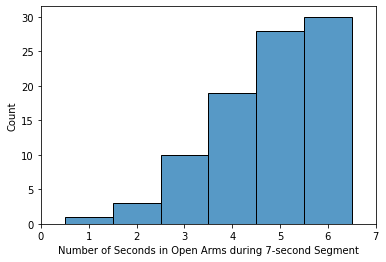

In [92]:
import seaborn as sns

sns.histplot(np.sum(np.array(mouse_roi_segs),axis=1),binwidth=0.3,discrete=True)
plt.xlim([0,7])
plt.xlabel("Number of Seconds in Open Arms during 7-second Segment")
plt.show()

In [86]:
np.max(np.sum(np.array(mouse_roi_segs),axis=1))

6.0

In [72]:
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 0
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 3
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)

scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]

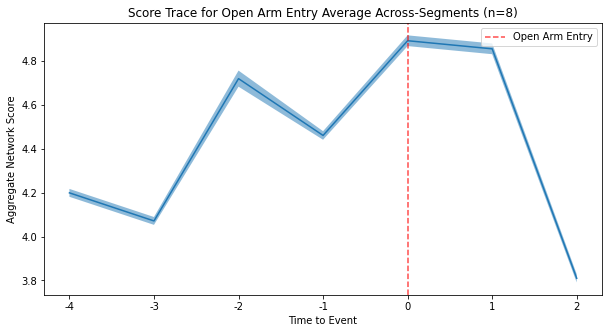

In [82]:
plt.figure(figsize=(10,5))
mean = np.mean(np.array(mouse_score_segs)[seg_mask==1],axis=0)
stderr = np.std(np.array(mouse_score_segs)[seg_mask==1],axis=0) / np.sqrt(np.sum(mouse_score_segs))

plt.plot(mean)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
plt.fill_between(range(7),mean+stderr,mean-stderr,alpha=0.5)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
plt.legend()
plt.title("Score Trace for Open Arm Entry Average Across-Segments (n={})".format(scores_final.shape[0]))
plt.savefig(FIGURE_PATH + "CUS-EPM CA to OA Entry Network Trace Across-Segments.svg")
plt.show()

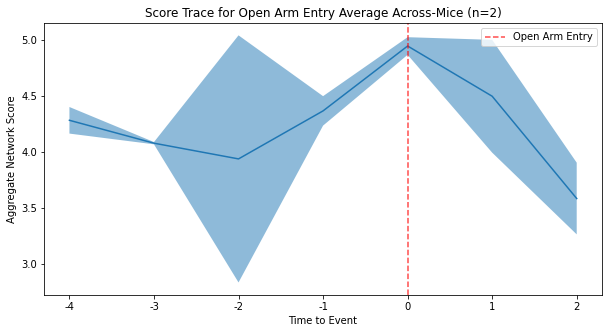

In [76]:
scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])
    
plt.figure(figsize=(10,5))
plt.plot(mean)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
plt.fill_between(range(7),mean+stderr,mean-stderr,alpha=0.5)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
plt.legend()
plt.title("Score Trace for Open Arm Entry Average Across-Mice (n={})".format(mouse_mean_scores.shape[0]))
plt.savefig(FIGURE_PATH + "CUS-EPM CA to OA Entry Network Trace Across-Mice.svg")
plt.show()

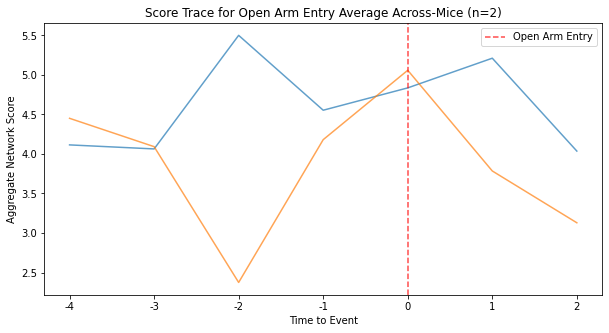

In [79]:
scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])
    
plt.figure(figsize=(10,5))
plt.plot(mouse_mean_scores[0],alpha=0.7)
plt.plot(mouse_mean_scores[1],alpha=0.7)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
#plt.fill_between(range(7),mean+stderr,mean-stderr,alpha=0.5)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
plt.legend()
plt.title("Score Trace for Open Arm Entry Average Across-Mice (n={})".format(mouse_mean_scores.shape[0]))
plt.savefig(FIGURE_PATH + "CUS-EPM CA to OA Entry Network Trace Individual Mice.svg")
plt.show()

In [45]:
mouse_mean_scores.shape

(2, 7)

In [48]:
np.unique(mouse)

array(['MouseC5C13'], dtype='<U10')

In [38]:
seg_mask

array([False,  True, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [80]:
time_points_dict = {}
for mouse in np.unique(mouse_final):
    time_points_dict[mouse] = []
    
for i, mouse in enumerate(mouse_final):
    
    for j in np.unique(mouse_final):
        if j==mouse:
            time_points_dict[mouse].append(time_final[i])
        else:
            time_points_dict[j].append(np.nan)
            
df = pd.DataFrame.from_dict(time_points_dict)
df.to_csv(PROJECT_PATH + "CUS_EPM_CA_to_OA_timepoints.csv")

In [81]:
df

,MouseC5C12,MouseC5C13
0,350.0,NaN
1,446.0,NaN
2,557.0,NaN
3,807.0,NaN
4,874.0,NaN
5,907.0,NaN
6,NaN,863.0
7,NaN,944.0


In [83]:
cus_data_dict.keys()

dict_keys(['X', 'X_power_1_2', 'X_coh_1_2', 'X_gc_1_2', 'y', 'y_roi', 'y_mouse', 'y_time', 'y_Homecage', 'y_task', 'labels'])

In [ ]:
cus_data_dict

### Entry Plots

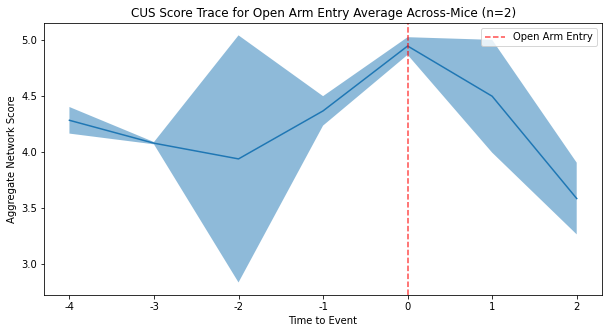

In [21]:
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

df_proj = df
rois = df_proj["roi"].to_numpy()
scores = df_proj["agg score"].to_numpy()
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = 1 - np.isnan(rois)
mask = np.logical_and(roi_mask,intask)

filt_rois = rois[mask==1]%2
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []
for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==1 and temp_rois[idx-1]==0:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 0
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 3
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)
scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]



scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])
    
plt.figure(figsize=(10,5))
plt.plot(mean)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
plt.fill_between(range(7),mean+stderr,mean-stderr,alpha=0.5)
plt.ylabel("Aggregate Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
plt.legend()
plt.title("CUS Score Trace for Open Arm Entry Average Across-Mice (n=2)")
plt.savefig(FIGURE_PATH + "CUS CA to OA Entry Network Trace Across-Mice.svg")
plt.show()

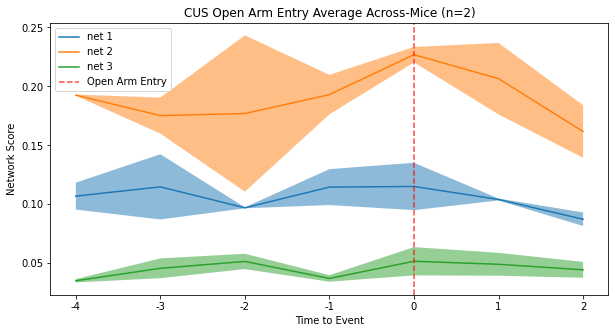

In [22]:
FIGURE_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Figures/"

df_proj = df
rois = df_proj["roi"].to_numpy()
scores = np.hstack((df_proj["net 1 scores"].to_numpy().reshape(-1,1),
                    df_proj["net 2 scores"].to_numpy().reshape(-1,1),
                    df_proj["net 3 scores"].to_numpy().reshape(-1,1)))
mouse = df_proj["mouse"].to_numpy()
intask = df_proj["task"].to_numpy()
time = df_proj["time"].to_numpy()
roi_mask = 1 - np.isnan(rois)
mask = np.logical_and(roi_mask,intask)

filt_rois = rois[mask==1]%2
scores_filt = scores[mask==1]
mouse_filt = mouse[mask==1]
time_filt = time[mask==1]

mouse_roi_segs = []
mouse_score_segs = []
mouse_id = []
idx_id = []
time_id = []
for mouse in np.unique(mouse_filt):
    mouse_mask = mouse_filt==mouse
    
    temp_rois = filt_rois.squeeze()[mouse_mask==1]
    temp_scores = scores_filt.squeeze()[mouse_mask==1]
    temp_time = time_filt.squeeze()[mouse_mask==1]
    
    for idx, roi in enumerate(temp_rois):
        
        if (idx > 3) and idx < (len(temp_rois) - 3):
            #print(idx)
            if temp_rois[idx]==1 and temp_rois[idx-1]==0:
                roi_seg = temp_rois[idx-4:idx+3]
                score_seg = temp_scores[idx-4:idx+3]

                mouse_roi_segs.append(np.array(roi_seg))
                mouse_score_segs.append(np.array(score_seg))
                mouse_id.append(mouse)
                idx_id.append(idx)
                time_id.append(temp_time[idx])
                
pre_zero_mask = np.sum(np.array(mouse_roi_segs)[:,:4],axis=1) == 0
post_one_mask = np.sum(np.array(mouse_roi_segs)[:,4:],axis=1) == 3
seg_mask = np.logical_and(pre_zero_mask,post_one_mask)
scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]
idx_final = np.array(idx_id)[seg_mask==1]
time_final = np.array(time_id)[seg_mask==1]



scores_final = np.array(mouse_score_segs)[seg_mask==1]
mouse_final = np.array(mouse_id)[seg_mask==1]

mouse_mean_scores = []

for mouse in np.unique(mouse_final):
    mouse_mask = mouse_final==mouse
    mouse_mean_scores.append(np.mean(scores_final[mouse_mask==1,:,:],axis=0))
    
mouse_mean_scores = np.array(mouse_mean_scores)
mean = np.mean(mouse_mean_scores,axis=0)
stderr = np.std(mouse_mean_scores,axis=0) / np.sqrt(mouse_mean_scores.shape[0])

plt.figure(figsize=(10,5))

for i in range(3):
    plt.plot(mean[:,i],label="net {}".format(i+1))
    plt.fill_between(range(7),mean[:,i]+stderr[:,i],mean[:,i]-stderr[:,i],alpha=0.5)
plt.axvline(x=4,color="red",linestyle="dashed",alpha=0.7,label="Open Arm Entry")
plt.ylabel("Network Score")
plt.xlabel("Time to Event")
plt.xticks(range(7), np.arange(7) - 4)
plt.legend()
plt.title("CUS Open Arm Entry Average Across-Mice (n=2)")
plt.savefig(FIGURE_PATH + "CUS EPM CA to OA Entry Individaul Network Trace Across-Mice.svg")
plt.show()

In [17]:
mouse_final

array(['MouseC5C12', 'MouseC5C12', 'MouseC5C12', 'MouseC5C12',
       'MouseC5C12', 'MouseC5C12', 'MouseC5C13', 'MouseC5C13'],
      dtype='<U10')

In [23]:
y[y_mouse=="C

NameError: name 'y_condition' is not defined